## Podział na jednostki podwyrazowe



### Słownik nie może być za duży…



Jeśli używamy wyuczalnych zanurzeń słów (embeddingów), wówczas musimy
je dopisać do listy parametrów całego modelu — jest to $|V|n$ wag,
gdzie $n$ to rozmiar embeddingów; w wypadku uczenia dodatkowo musimy
jeszcze pamiętać związane z embeddingami gradienty. Pamięć RAM karty
graficznej jest rzecz jasna ograniczona, słownik więc nie może być
dowolnie duży. Dla danego modelu karty graficznej dość łatwo ustalić
maksymalny rozmiar słownika — jest „twarde” ograniczenie, które musimy
spełnić.



#### Czy rzeczywiście słownik może być taki duży?



Ile jest różnych form fleksyjnych w języku polskim? Zobaczmy w słowniku PoliMorf…



In [1]:
! wget -q 'http://zil.ipipan.waw.pl/PoliMorf?action=AttachFile&do=get&target=PoliMorf-0.6.7.tab.gz' -O - | zcat | cut -f 1 | uniq | head -n 20

a
aa
AA
Aachen
Aalborg
Aalborgiem
Aalborgowi
Aalborgu
AAP
Aar
Aarem
Aarowi
Aaru
Aarze
Aara
Aarą
Aarę
Aaro
Aary
Aarze
uniq: błąd zapisu: Przerwany potok


In [2]:
! wget -q 'http://zil.ipipan.waw.pl/PoliMorf?action=AttachFile&do=get&target=PoliMorf-0.6.7.tab.gz' -O - | zcat | cut -f 1 | sort -u | wc -l

3844535


**Pytanie** W którym języku europejskim wyrazów będzie jeszcze więcej niż języku polskim?

Tak naprawdę form jest jeszcze więcej, oczywiście PoliMorf nie wyczerpuje zbioru…

**Pytanie** Podaj przykłady „oczywistych” wyrazów, których nie ma w PoliMorfie. Jak w sposób systematyczny szukać takich wyrazów?

Z drugiej strony, w PoliMorfie jest dużo dziwnych, „sztucznych” wyrazów.



In [3]:
! wget -q 'http://zil.ipipan.waw.pl/PoliMorf?action=AttachFile&do=get&target=PoliMorf-0.6.7.tab.gz' -O - | zcat | cut -f 1 | shuf -n 20

niebiałościenną
nieponadosobowości
nieknerający
inspektoratów
Korytkowskich
elektrostatyczności
Okola
bezsłowny
indygowcu
gadany
nieładowarkowościach
niepawężnicowate
Thom
poradlmy
olejący
Ziemianinów
stenotropizmami
wigiliowości
pognanej
niekinezyterapeutycznym


Inaczej, zobaczmy, ile różnych wyrazów jest w jakimś rzeczywistym zbiorze tekstów, rozpatrzmy
teksty zebrane na potrzeby identyfikacji płci autora tekstu:



In [1]:
! git clone --single-branch --depth 1 git://gonito.net/petite-difference-challenge2

# Out[7]:

In [1]:
! xzcat petite-difference-challenge2/train/in.tsv.xz | perl -C -ne 'print "$&\n" while/\p{L}+/g;'  | sort -u > vocab.txt

In [4]:
! head -n 50 vocab.txt

ˆ
ˇ
ﾟ
a
A
á
Á
à
À
ă
Ă
â
Â
å
Å
ä
Ä
Ã
ā
aa
aA
Aa
AA
aĂ
AĂ
aâ
aÂ
Aâ
aÅ
aÄ
Âª
aaa
aAa
Aaa
AaA
AAa
AAA
aaaa
aAaa
Aaaa
AaAa
AAaa
AAAa
AAAA
aaaaa
Aaaaa
AaaaA
AAaaa
AAAAA
aaaaaa


In [5]:
! wc -l vocab.txt

2974556 vocab.txt


Co gorsza, nawet jak weźmiemy cały taki słownik bez ograniczeń i tak
nie pokryje on sporej części tekstów przetwarzanych w czasie inferencji.
Zobaczmy, ilu wyrazów ze zbioru deweloperskiego nie będzie w słowniku.



In [6]:
! cat petite-difference-challenge2/dev-0/in.tsv | perl -C -ne 'print "$&\n" while/\p{L}+/g;'  | sort -u | comm vocab.txt - -13 | wc -l

81380


Takie wyrazy nazywamy wyrazami **OOV** (*out-of-vocabulary*).



### Obcięcie słownika



Najprostszy sposób ograniczenia słownika to po prostu obcięcie do $N$ najczęstszych słów.

Spróbujmy zastosować do korpusu „płci”:



In [7]:
! xzcat petite-difference-challenge2/train/in.tsv.xz | perl -C -ne 'print "$&\n" while/\p{L}+/g;' | sort | uniq -c | sort -k 1rn | head -n 50000 | sort -k 2 > vocab50000.txt

sort: błąd zapisu: 'standardowe wyjście': Przerwany potok
sort: błąd zapisu


Daje to lepszy efekt niż można się spodziewać. Odrzucamy w ten sposób
tylko bardzo rzadkie słowa (albo takie, które wystąpiły tylko raz w
korpusie — tzw. *hapax legomena*), choć tych słów jest bardzo dużo.

**Zagadka**: 50000 najczęstszych słów (1,9% **typów**) pokrywa jaki odsetek **wystąpień**?

Rozkład normalny w języku nie jest… normalny — nie spotkamy się z nim
badając języki. W tekstach dominują „skrzywione” rozkłady z długimi,
„chudymi” ogonami.



In [1]:
! xzcat petite-difference-challenge2/train/in.tsv.xz | perl -C -ne 'print "$&\n" while/\p{L}+/g;' | sort | uniq -c | sort -k 1rn | cut -f 1 > freqs.txt

'word-distribution.png'

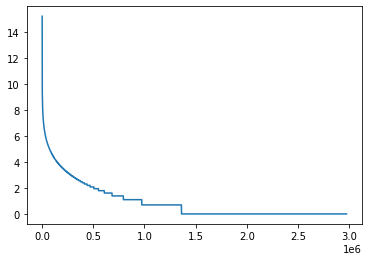

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
from math import log

freqs = []

with open('freqs.txt', 'r') as fh:
  for line in fh:
     m = re.match(r'\s*(\d+)', line)
     if m:
        freqs.append(log(float(m.group(1))))

plt.plot(range(len(freqs)), freqs)
fname = 'word-distribution.png'
plt.savefig(fname)
fname

[[file:# Out[25]:

    'word-distribution.png'

![img](./obipy-resources/c0TrCn.png)]]



### Lematyzacja



Lematyzacja wydaje się dobrym pomysłem, zwłaszcza dla języków dla bogatej fleksji:

-   znacznie redukujemy słownik,
-   formy fleksyjne tego samego wyrazu są traktowane tak samo (co wydaje się słuszne).

W praktyce współcześnie **nie** stosuje się lematyzacji (w połączeniu z
metodami opartymi na sieciach neuronowych):

-   lematyzacja wymaga wiedzy językowej (reguł lub słownika),
    wytworzenie takiej wiedzy może być kosztowne, obecnie preferowane
    są metody niezależne od języka;
-   tracimy pewną informację niesioną przez formę fleksyjną (co w szczególnych
    przypadkach może być niefortunne, np. *aspiracja* i *aspiracje*);
-   lematyzacja nie jest trywialnym problemem ze względu na niejednoznaczności
    (*Lekarzu, lecz się sam*);
-   niektóre niejednoznaczności są seryjne, wybór lematu może być arbitralny,
    np. czy *posiadanie*, *gotowanie*, *skakanie* to rzeczowniki czy czasowniki?
    a *urządzenie*, *mieszkanie*?
-   zazwyczaj sieci neuronowe (czy nawet prostsze modele typu Word2vec)
    są w stanie nauczyć się rekonstruowania zależności między formami fleksyjnymi
    (i więcej: błędnych form, błędów ortograficznych, form archaicznych itd.)



### Zejście na poziom znaków



Skoro słownik wyrazów jest zbyt duży, to może zejść na poziom znaków?

-   pojedynczy znak alfabetu wprawdzie nic nie znaczy (co znaczy *h*?)

-   … ale rozmiar wejścia przy kodowaniu gorącą jedynką
    dramatycznie się zmniejsza

-   może działać, jeśli dodać wielowarstwową sieć
    neuronową

-   … ale może być bardzo kosztowne obliczeniowo

A może coś pośredniego między znakami a wyrazami?



### BPE



Ani znaki, ani wyrazy — coś pomiędzy: jednostki podwyrazowe (*subword
units*). Moglibyśmy np. dzielić wyraz *superkomputera* na dwie
jednostki *super/+/komputera*, a może nawet trzy: *super/+/komputer/+/a*?

Najpopularniejszy algorytm podziału na jednostki podwyrazowe to BPE
(*byte-pair encoding*), zainspirowany algorytmami kompresji danych.
Lista jednostek jest automatycznie indukowana na podstawie tekstu (nie
potrzeba żadnej wiedzy o języku!). Ich liczba musi być natomiast z góry
określona.

W kroku początkowym zaznaczamy końce wyrazów (tokenów), robimy to po
to, żeby jednostki podwyrazowe nie przekraczały granic wyrazów.

Następnie wykonujemy tyle kroków iteracji, ile wynosi rozmiar zadanego
słownika. W każdym kroku szukamy najczęstszego bigramu, od tego
momentu traktujemy go jako całostkę (wkładamy go do „pudełka”).

![img](./bpe.png)



#### Implementacja w Pythonie



In [10]:
from collections import Counter

def replace_bigram(l, b, r):
   i = 0
   while i < len(l) - 1:
      if (l[i], l[i+1]) == b:
           l[i:i+2] = [r]
      i += 1
   return l

def learn_bpe_vocab(d, max_vocab_size):
   d = list(d.replace(' ', '$') + '$')

   vocab = []

   for ix in range(0, max_vocab_size):
       bigrams = [(d[i], d[i+1]) for i in range(0, len(d) - 1) if d[i][-1] != '$']
       selected_bigram = Counter(bigrams).most_common(1)[0][0]

       new_subword = selected_bigram[0] + selected_bigram[1]
       d = replace_bigram(d, selected_bigram, new_subword)

       vocab.append(new_subword)

   return vocab

vocab1 = learn_bpe_vocab('to be or not to be that is the question', 10)
vocab1

['e$', 'to', 'to$', 'be$', 't$', 'th', 'or', 'or$', 'no', 'not$']

Słownik jednostek podwyrazowych możemy zastosować do dowolnego tekstu, np. do tekstu,
na którym słownik był wyuczony:



In [11]:
def apply_bpe_vocab(vocab, d):
   d = list(d.replace(' ', '$') + '$')
   vocab_set = set(vocab)

   modified = True
   while modified:
       ix = 0
       modified = False
       while ix < len(d) - 1:
           bigram = d[ix] + d[ix+1]
           if bigram in vocab_set:
               d[ix:ix+2] = [bigram]
               modified = True
           else:
               ix += 1

   return d

' '.join(apply_bpe_vocab(vocab1, 'to be or not to be that is the question'))

'to$ be$ or$ not$ to$ be$ th a t$ i s $ th e$ q u e s t i o n $'

Zauważmy, że oprócz jednostek podwyrazowych zostały izolowane litery,
zazwyczaj dodajemy je do słownika. (I zazwyczaj, słownik jest trochę
większy niż wartość podana jako parametr przy uczeniu BPE — jest
większy o znaki i specjalne tokeny typu `UNK`, `BOS`, `EOS`, `PAD`.)

**Pytanie**: Jaki problem może pojawić przy zastosowaniu BPE dla tekstu,
gdzie pojawiają się chińskie znaki? Jak można sobie z nim poradzić?

Słownik jednostek podwyrazowych można stosować dla dowolnego tekstu:



In [12]:
' '.join(apply_bpe_vocab(vocab1, 'tom will be the best'))

'to m $ w i l l $ be$ th e$ b e s t$'

Jak można zauważyć algorytm BPE daje dwa rodzaje jednostek podwyrazowych:

-   jednostki, które mogą doklejane na początku wyrazu;
-   jednostki, które stanowią koniec wyrazu, w szczególności są całym wyrazem.



#### Gotowa implementacja



Po raz pierwszy BPE użyto do neuronowego tłumaczenia maszynowego.
Użyjmy modułu autorstwa Rica Sennricha ([https://github.com/rsennrich/subword-nmt](https://github.com/rsennrich/subword-nmt)).



In [1]:
! pip install subword-nmt

Wyindukujmy słownik dla zbioru uczącego zadania identyfikacji płci
autora tekstu:



In [1]:
! xzcat petite-difference-challenge2/train/in.tsv.xz | perl -C -ne 'print "$&\n" while/\p{L}+/g;' | python -m subword_nmt.learn_bpe -s 50000 -v > bpe_vocab.txt

Procedura trwa kilka minut, trzeba uzbroić się w cierpliwość (ale wypisywanie bigramów przyspieszy!).

    pair 0: n i -> ni (frequency 17625075)
    pair 1: i e -> ie (frequency 11471590)
    pair 2: c z -> cz (frequency 9143490)
    pair 3: ni e</w> -> nie</w> (frequency 7901783)
    pair 4: p o -> po (frequency 7790826)
    pair 5: r z -> rz (frequency 7542046)
    pair 6: s t -> st (frequency 7269069)
    pair 7: e m</w> -> em</w> (frequency 7207280)
    pair 8: d z -> dz (frequency 6860931)
    pair 9: s z -> sz (frequency 6609907)
    pair 10: r a -> ra (frequency 6601618)
    pair 11: o w -> ow (frequency 6395963)
    pair 12: i e</w> -> ie</w> (frequency 5906869)
    pair 13: n a -> na (frequency 5300380)
    pair 14: r o -> ro (frequency 5181363)
    pair 15: n a</w> -> na</w> (frequency 5125807)
    pair 16: a ł -> ał (frequency 4786696)
    pair 17: j e -> je (frequency 4599579)
    pair 18: s i -> si (frequency 4300984)
    pair 19: a l -> al (frequency 4276823)
    pair 20: t e -> te (frequency 4033344)
    pair 21: w i -> wi (frequency 3939063)
    pair 22: c h</w> -> ch</w> (frequency 3919410)
    pair 23: c h -> ch (frequency 3661410)
    pair 24: k o -> ko (frequency 3629840)
    pair 25: z a -> za (frequency 3625424)
    pair 26: t a -> ta (frequency 3570094)
    pair 27: p rz -> prz (frequency 3494551)
    pair 28: g o</w> -> go</w> (frequency 3279997)
    pair 29: a r -> ar (frequency 3081492)
    pair 30: si ę</w> -> się</w> (frequency 2973681)
    ...
    pair 49970: brz mieniu</w> -> brzmieniu</w> (frequency 483)
    pair 49971: bieżą cych</w> -> bieżących</w> (frequency 483)
    pair 49972: biegu nkę</w> -> biegunkę</w> (frequency 483)
    pair 49973: ban kowości</w> -> bankowości</w> (frequency 483)
    pair 49974: ba ku</w> -> baku</w> (frequency 483)
    pair 49975: ba cznie</w> -> bacznie</w> (frequency 483)
    pair 49976: Przypad kowo</w> -> Przypadkowo</w> (frequency 483)
    pair 49977: MA Ł -> MAŁ (frequency 483)
    pair 49978: Lep pera</w> -> Leppera</w> (frequency 483)
    pair 49979: Ko za -> Koza (frequency 483)
    pair 49980: Jak byś</w> -> Jakbyś</w> (frequency 483)
    pair 49981: Geni alne</w> -> Genialne</w> (frequency 483)
    pair 49982: Że nada</w> -> Żenada</w> (frequency 482)
    pair 49983: ń czykiem</w> -> ńczykiem</w> (frequency 482)
    pair 49984: zwie ń -> zwień (frequency 482)
    pair 49985: zost ałaś</w> -> zostałaś</w> (frequency 482)
    pair 49986: zni szczona</w> -> zniszczona</w> (frequency 482)
    pair 49987: ze stawi -> zestawi (frequency 482)
    pair 49988: za sób</w> -> zasób</w> (frequency 482)
    pair 49989: węd rówkę</w> -> wędrówkę</w> (frequency 482)
    pair 49990: wysko czyła</w> -> wyskoczyła</w> (frequency 482)
    pair 49991: wyle czenia</w> -> wyleczenia</w> (frequency 482)
    pair 49992: wychowaw cze</w> -> wychowawcze</w> (frequency 482)
    pair 49993: w t -> wt (frequency 482)
    pair 49994: un da -> unda (frequency 482)
    pair 49995: udzie lałem</w> -> udzielałem</w> (frequency 482)
    pair 49996: tę czy</w> -> tęczy</w> (frequency 482)
    pair 49997: tro sce</w> -> trosce</w> (frequency 482)
    pair 49998: słusz ności</w> -> słuszności</w> (frequency 482)
    pair 49999: su me</w> -> sume</w> (frequency 482

Zastosujmy teraz wyindukowany słownik BPE dla jakiegoś rzeczywistego tekstu.



In [13]:
! echo 'Cierpiałem na straszne lagi – kilkanaście sekund lub dłużej czarnego ekranu przy próbie przełączenia się / uruchomienia prawie każdej aplikacji. Dodatkowo telefon mi się wyłączał czasem bez powodu – sam z siebie, albo resetował. Ostatnio nawet przeglądarka zaczęła się często zawieszać i Android proponował wymuszone zamknięcie. Do tego te problemy z połączeniem do komputera przez USB.' | perl -C -ne 'print "$& " while/\p{L}+/g;' | python -m subword_nmt.apply_bpe -c bpe_vocab.txt

Cier@@ piałem na straszne la@@ gi kilkanaście sekund lub dłużej czarnego ekranu przy próbie przełą@@ czenia się uruchomienia prawie każdej aplikacji Dodatkowo telefon mi się wyłą@@ czał czasem bez powodu sam z siebie albo rese@@ tował Ostatnio nawet przeglądarka zaczęła się często zawie@@ szać i Android proponował wymu@@ szone zamknięcie Do tego te problemy z połączeniem do komputera przez USB 

Ta konkretna implementacja zaznacza za pomocą sekwencji ~@@ ~ koniec jednostki podwyrazowej.

